This example conducts a statistical analysis of the initial optwrf database in an attempt to tease out relationships among the different parameters.

Last Updated by Jeffrey Sward on May 5, 2020.

In [1]:
import csv
import datetime
import math
import random
import sys
import time

import seaborn as sns
import pandas as pd
import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [47]:
def daylight(day, latitude=40):
    """
    This function calculates the number of daylight hours given jullian day of the year, and the latitude.
    For the optwrf work, I have set the default latitude to the 40th parallel since that cuts through
    the center of the domain. 
    """
    P = math.asin(0.39795 * math.cos(0.2163108 + 2 * math.atan(0.9671396 * math.tan(.00860 * (day - 186)))))
    pi = math.pi
    daylightamount = 24 - (24 / pi) * math.acos((math.sin(0.8333 * pi / 180) + 
                                                 math.sin(latitude * pi / 180) * math.sin(P)) 
                                                / (math.cos(latitude * pi / 180) * math.cos(P)))
    return daylightamount

In [48]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_database_050420.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data['fitness'].values[data['fitness'] > 6 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
# Calculate the the normalized number of daylight hours
data['j_date'] = data.start_date.apply(lambda x: x.timetuple().tm_yday)
data['day_len'] = [daylight(data.j_date.iloc[N]) for N in range(len(data.j_date))]
data['day_len_frac'] = data['day_len']/max(data['day_len'])
# Calculate the corrected fitness based upon the day length
data['fitness_corrected'] = data.fitness/data.day_len_frac
data.iloc[:5,:]


/Users/swardy9230/opt/anaconda3/envs/runwrf/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime,season,j_date,day_len,day_len_frac,fitness_corrected
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00,winter,363,9.346323,0.622404,NaN
1,2011-11-27,13,5,7,5,5,14,1,2034.423190,4:39:34.359051,fall,331,9.660898,0.643353,3162.219899
2,2011-09-01,14,4,7,1,1,11,2,NaN,0:00:00.042498,fall,244,13.118862,0.873631,NaN
3,2011-04-06,18,1,5,7,9,16,1,NaN,6:00:01.733799,spring,96,12.838070,0.854932,NaN
4,2011-05-02,14,7,1,7,8,94,1,NaN,6:00:06.829933,spring,122,13.904221,0.925930,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,2011-12-29,4,99,24,4,7,3,1,636.979945,02h 05m 17s,winter,363,9.346323,0.622404,1023.418484
1119,2011-04-27,5,99,1,4,7,6,1,1494.732208,00h 53m 51s,spring,117,13.711911,0.913124,1636.943476
1120,2011-03-25,4,99,99,4,7,6,1,777.975892,01h 17m 59s,spring,84,12.312584,0.819938,948.823007
1121,2011-04-20,10,1,24,1,12,3,1,1165.439926,01h 59m 37s,spring,110,13.430486,0.894383,1303.066122


## Random Forest Model

In this section, I train a random forest regression model to compare the relative feature importances. 

In [59]:
# Drop the start_date variable to train the random forest regressor
RFfeatures = data[['mp_physics', 'ra_lw_physics', 'ra_sw_physics', 
                  'sf_surface_physics', 'bl_pbl_physics', 'cu_physics', 
                  'fitness', 'fitness_corrected']]

# Drop rows where there are NaN values
RFfeatures = RFfeatures.dropna()

# Convert param_ids back to names so the RF algorithm will recognize them as separe categories
RFfeatures['mp_physics'] = num2name(RFfeatures.mp_physics, 'microphysics')
RFfeatures['ra_lw_physics'] = num2name(RFfeatures.ra_lw_physics, 'lw radiation')
RFfeatures['ra_sw_physics'] = num2name(RFfeatures.ra_sw_physics, 'sw radiation')
RFfeatures['sf_surface_physics'] = num2name(RFfeatures.sf_surface_physics, 'land surface')
RFfeatures['bl_pbl_physics'] = num2name(RFfeatures.bl_pbl_physics, 'PBL')
RFfeatures['cu_physics'] = num2name(RFfeatures.cu_physics, 'cumulus')
RFfeatures.iloc[:5,:]

,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,fitness,fitness_corrected
1,sbu-ylin,new goddard,flg,clm4,mynn2,ysu gfs sas,2034.423190,3162.219899
5,wsm6,held-suarez,dudia,pleim-xiu,mynn2,bmj,1363.634615,2189.119078
6,goddard,held-suarez,flg,5 layer,temf,ysu gfs sas,1211.080139,1709.101376
7,nssl 1mom no hail,cam,rrtmg fast,noah,acm2,grell-freitas,770.247851,1100.724772
8,p3 2mom,rrtmg fast,cam,noah-mp,mynn2,new tiedtke,807.914899,985.336759


In [60]:
# One-hot encode the data using pandas get_dummies
RFfeatures = pd.get_dummies(RFfeatures)
RFfeatures.iloc[:5,:]

,fitness,fitness_corrected,mp_physics_cam5.1,mp_physics_eta,mp_physics_goddard,mp_physics_kressler,mp_physics_lin,mp_physics_milbrandt2mom,mp_physics_morrison2mom,mp_physics_nssl 1mom,...,cu_physics_grell3d,cu_physics_hwrf gfs sas,cu_physics_kain-fritsch,cu_physics_mod kain-fritsch,cu_physics_multi kain-fritsch,cu_physics_new tiedtke,cu_physics_old kain-fritsch,cu_physics_tiedtke,cu_physics_ysu gfs sas,cu_physics_zhang-mcfarlane
1,2034.423190,3162.219899,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1363.634615,2189.119078,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1211.080139,1709.101376,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,770.247851,1100.724772,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,807.914899,985.336759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [61]:
# Labels are the values we want to predict
labels = RFfeatures['fitness']
labels_corrected = RFfeatures['fitness_corrected']

# Remove the labels from the features
RFfeatures = RFfeatures.drop(['fitness', 'fitness_corrected'], axis = 1)
feature_names = list(RFfeatures.columns)

# Train the Random Forest Regressor model
model = RandomForestRegressor()
# model.fit(RFfeatures, labels)
model.fit(RFfeatures, labels_corrected)
# print(model.feature_importances_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

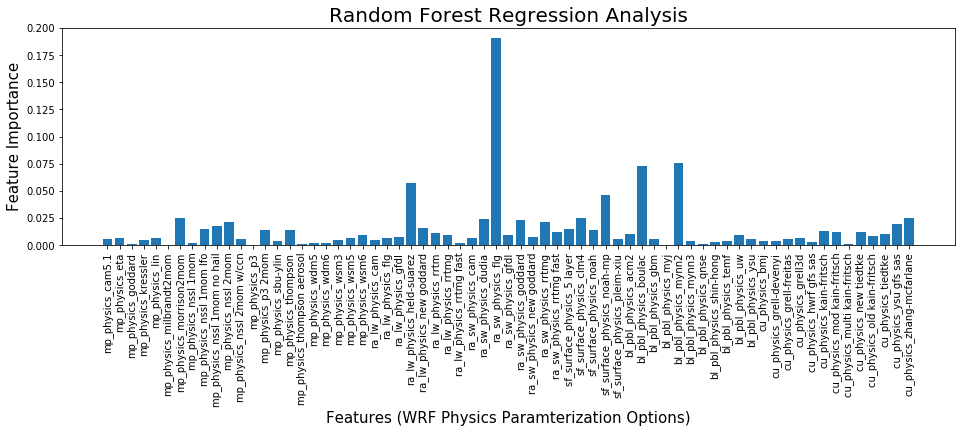

In [62]:
# Plot the RF model feature importances
fig, ax = plt.subplots(figsize=(16, 4))
ax.bar(feature_names, model.feature_importances_)
ax.set_xlabel('Features (WRF Physics Paramterization Options)', fontsize = 15)
ax.set_ylabel('Feature Importance', fontsize = 15)
ax.set_title('Random Forest Regression Analysis', fontsize = 20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    tick.label.set_rotation('vertical')

## Principle Component Analysis

In this section, I attempt to apply PCA to determine which physics are the most important. 
However, I have yet to figure out how to do this considering the categorical nature of 

In [28]:
PCA_data = data.drop(['runtime','season'], axis=1) 
PCA_data['start_date'] = data.start_date.apply(lambda x: x.timetuple().tm_yday)
# PCA_data = PCA_data.sort_values(by='fitness')
PCA_data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness
0,363,2,31,2,3,5,93,1,NaN
1,331,13,5,7,5,5,14,1,2034.423190
2,244,14,4,7,1,1,11,2,NaN
3,96,18,1,5,7,9,16,1,NaN
4,122,14,7,1,7,8,94,1,NaN
...,...,...,...,...,...,...,...,...,...
1118,363,4,99,24,4,7,3,1,636.979945
1119,117,5,99,1,4,7,6,1,1494.732208
1120,84,4,99,99,4,7,6,1,777.975892
1121,110,10,1,24,1,12,3,1,1165.439926


In [29]:
features = ['start_date', 'mp_physics', 'ra_lw_physics', 'ra_sw_physics', 'sf_surface_physics', 'bl_pbl_physics', 'cu_physics', 'sf_sfclay_physics']
# Separating out the features
x = PCA_data.loc[:, features].values
# Separating out the target
y = PCA_data.loc[:,['fitness']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [30]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5'])
pca.explained_variance_ratio_

array([0.20774531, 0.15408556, 0.13604282, 0.12923736, 0.11508092])

In [31]:
finalDf = pd.concat([principalDf, PCA_data[['start_date', 'mp_physics', 'ra_lw_physics', 'ra_sw_physics', 'sf_surface_physics', 'bl_pbl_physics', 'cu_physics', 'sf_sfclay_physics','fitness']]], axis = 1)

In [32]:
finalDf

,PC 1,PC 2,PC 3,PC 4,PC 5,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness
0,-0.478528,-0.895174,0.814241,-1.687054,0.632794,363,2,31,2,3,5,93,1,NaN
1,0.140303,0.130064,0.325741,-1.306328,0.623228,331,13,5,7,5,5,14,1,2034.423190
2,1.677525,0.541768,0.730621,-1.202464,-0.641868,244,14,4,7,1,1,11,2,NaN
3,-0.820826,0.708443,0.147836,0.603763,-0.334994,96,18,1,5,7,9,16,1,NaN
4,-1.884669,0.547290,1.046815,0.184366,-0.210543,122,14,7,1,7,8,94,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,1.470845,-1.597925,0.374383,-0.888028,1.593216,363,4,99,24,4,7,3,1,636.979945
1119,1.117170,-1.539695,0.977992,0.398702,-0.338813,117,5,99,1,4,7,6,1,1494.732208
1120,2.199373,-0.494878,0.620902,2.822429,2.185724,84,4,99,99,4,7,6,1,777.975892
1121,0.537135,-0.111637,-1.965983,0.985012,-0.644490,110,10,1,24,1,12,3,1,1165.439926


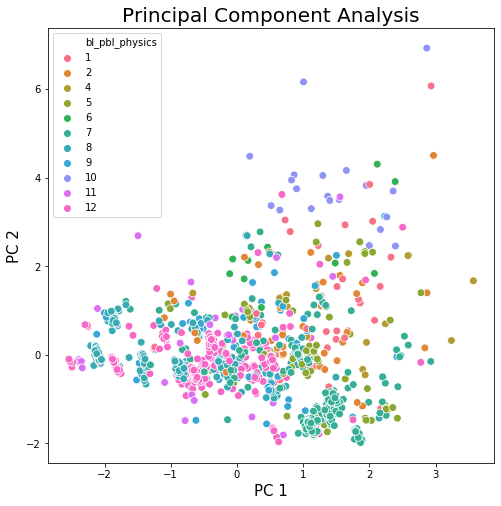

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Principal Component Analysis', fontsize = 20)
n_colors = finalDf['bl_pbl_physics'].nunique()
sns.scatterplot(finalDf.loc[:,'PC 1'], finalDf.loc[:,'PC 2'], 
                hue=finalDf.bl_pbl_physics, palette=sns.husl_palette(n_colors), s=60)


## Plots of each physics paramerization option vs. fitness

In [5]:
# Sort data by start_date to make the plots look cleaner
data = data.sort_values(by='start_date')
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime,season
1047,2011-01-01,5,99,1,4,7,3,1,824.036064,02h 13m 02s,winter
37,2011-01-01,8,4,99,5,9,7,1,1432.446184,5:22:22.863760,winter
909,2011-01-01,51,4,1,1,5,2,1,1418.596397,00h 52m 03s,winter
467,2011-01-01,21,24,2,7,1,16,1,807.817349,01h 14m 11s,winter
203,2011-01-01,6,5,99,7,9,1,1,NaN,06h 00m 08s,winter
...,...,...,...,...,...,...,...,...,...,...,...
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00,winter
433,2011-12-30,6,4,2,7,9,3,1,692.778015,01h 53m 35s,winter
5,2011-12-30,6,31,1,7,5,2,1,1363.634615,1:55:58.395966,winter
108,2011-12-30,2,4,24,5,9,94,1,890.534170,05h 09m 23s,winter


In [7]:
def format_plot(xlab='xlabel', ylab='ylabel'):
    # find and format dates
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    date_fmt = mdates.DateFormatter('%b')

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

    # round to nearest month
    datemin = np.datetime64(data['start_date'].iloc[0], 'm')
    datemax = np.datetime64(data['start_date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    
    # format x and y labels
    plt.xlabel(xlab, fontsize=18)
    plt.ylabel(ylab, fontsize=18)

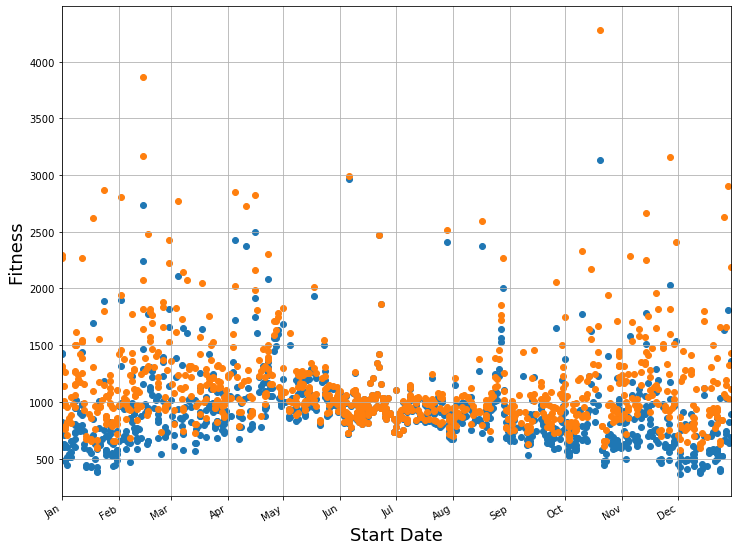

In [22]:
# Plot start_date vs fitness
start_date = data.start_date
fitness = data.fitness
f_daylight_normalized = data.fitness_corrected

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(start_date, fitness)
plt.scatter(start_date, f_daylight_normalized)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

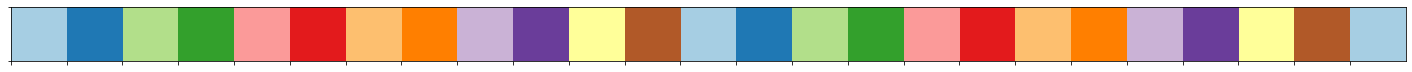

In [9]:
cmap1 = sns.color_palette('Paired',25)
sns.palplot(cmap1)

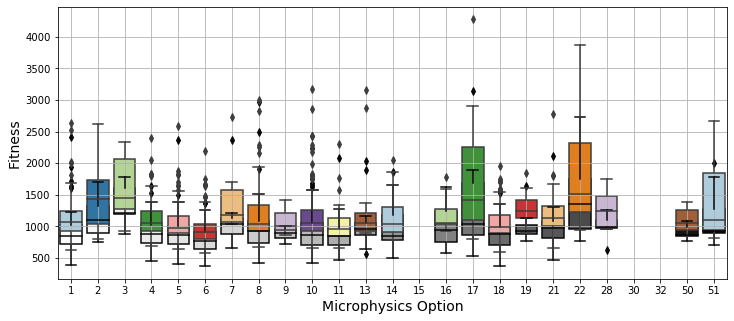

In [28]:
# Plot microphysics option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='mp_physics', y='fitness', data=data, palette=cmap1)
sns.boxplot(x='mp_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='mp_physics', y='fitness_corrected', data=data, palette=cmap1)

plt.xlabel('Microphysics Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvmp.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

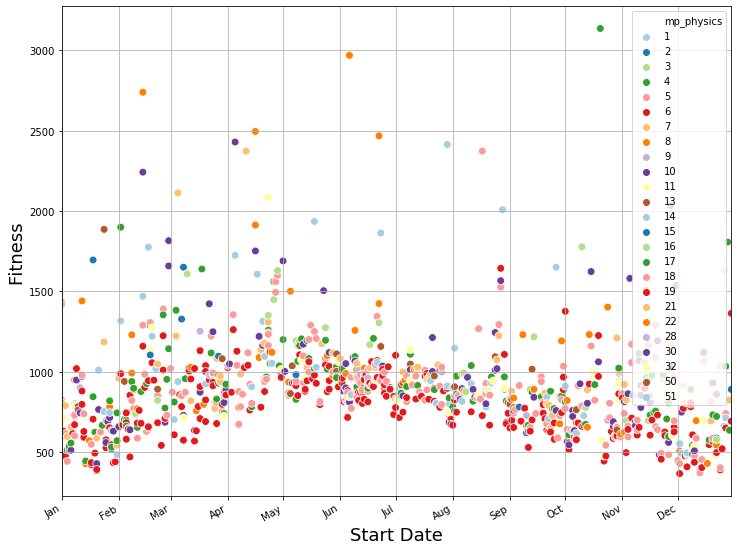

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.mp_physics, legend='full', palette=cmap1, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_mp.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

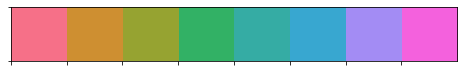

In [30]:
cmap2 = sns.husl_palette(8)
sns.palplot(cmap2)

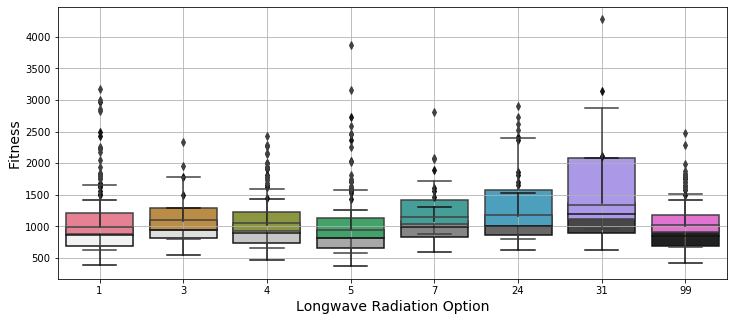

In [31]:
# Plot longwave radiation option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='ra_lw_physics', y='fitness', data=data, palette=cmap2)
sns.boxplot(x='ra_lw_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='ra_lw_physics', y='fitness_corrected', data=data, palette=cmap2)
plt.xlabel('Longwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvralw.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

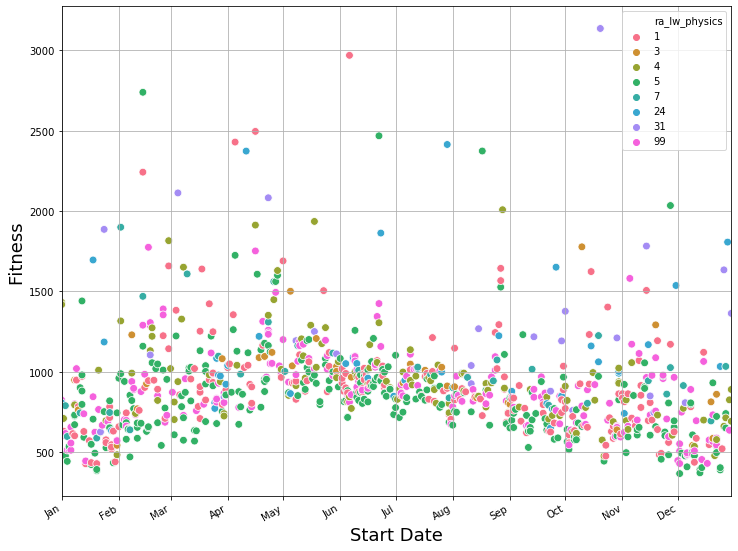

In [32]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.ra_lw_physics, legend="full", palette=cmap2, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_ralw.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [16]:
# Paired; n = 8; desat = 0.60
cmap3 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

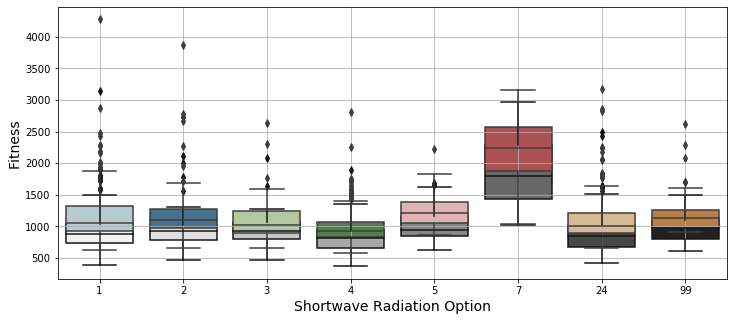

In [33]:
# Plot shortwave radiaiton option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='ra_sw_physics', y='fitness', data=data, palette=cmap3)
sns.boxplot(x='ra_sw_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='ra_sw_physics', y='fitness_corrected', data=data, palette=cmap3)
plt.xlabel('Shortwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvrasw.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

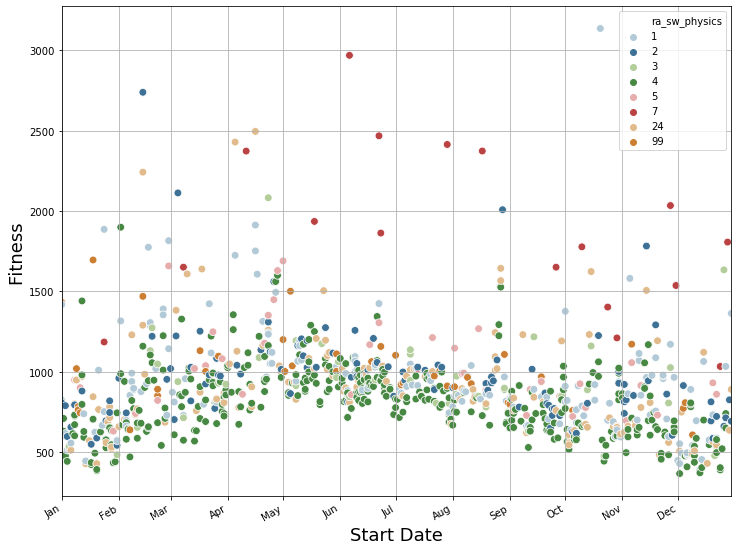

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.ra_sw_physics, legend="full", palette=cmap3, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_rasw.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [35]:
# Set2; n = 6; desat = 0.80
cmap4 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

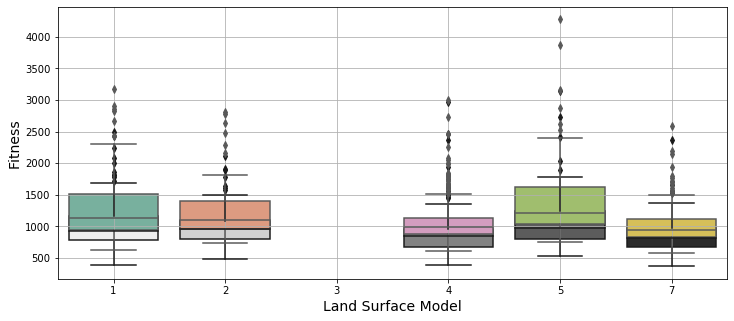

In [36]:
# Plot surface physics option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='sf_surface_physics', y='fitness', data=data, palette=cmap4)
sns.boxplot(x='sf_surface_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='sf_surface_physics', y='fitness_corrected', data=data, palette=cmap4)
plt.xlabel('Land Surface Model', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvlsm.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

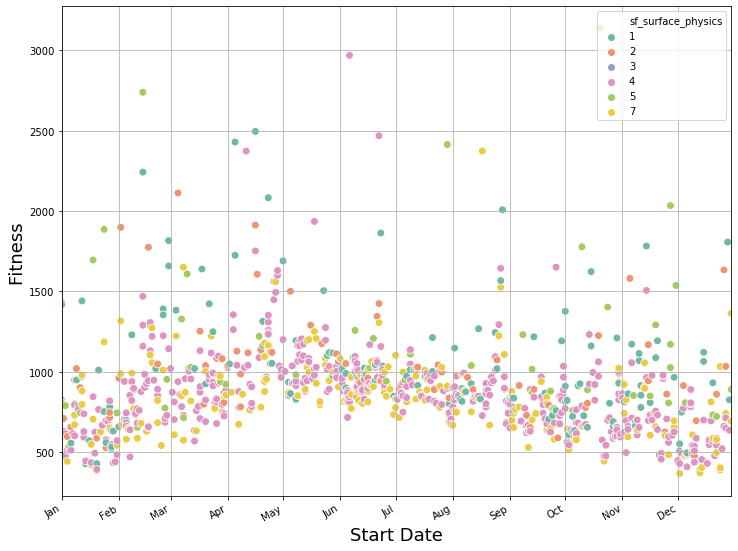

In [37]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.sf_surface_physics, legend="full", palette=cmap4, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_lsm.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [38]:
# Accent; n = 11; desat = 0.70
cmap5 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

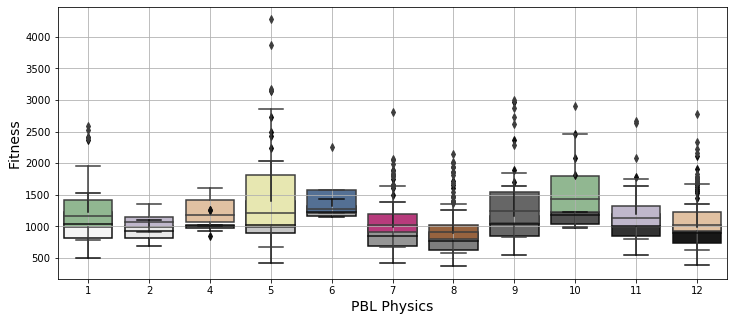

In [39]:
# Plot planetary boundary layer option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='bl_pbl_physics', y='fitness', data=data, palette=cmap5)
sns.boxplot(x='bl_pbl_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='bl_pbl_physics', y='fitness_corrected', data=data, palette=cmap5)
plt.xlabel('PBL Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvpbl.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

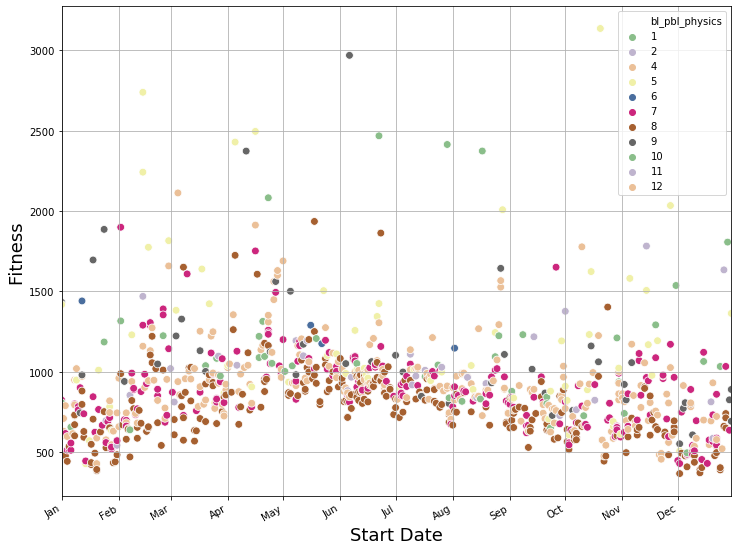

In [40]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.bl_pbl_physics, legend="full", palette=cmap5, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_pbl.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [41]:
# Dark2; n = 14; desat = 0.9
cmap6 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

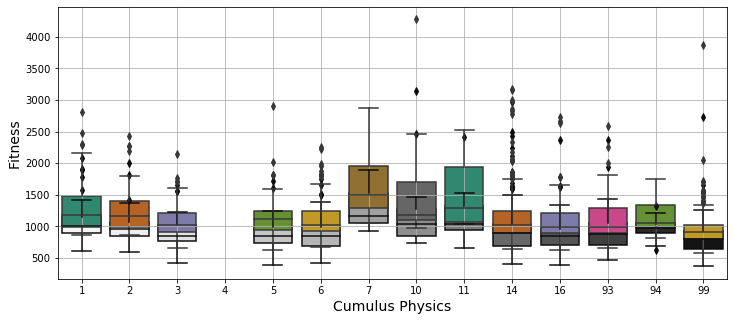

In [42]:
# Plot cumulus option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='cu_physics', y='fitness', data=data, palette=cmap6)
sns.boxplot(x='cu_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='cu_physics', y='fitness_corrected', data=data, palette=cmap6)
plt.xlabel('Cumulus Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvcu.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

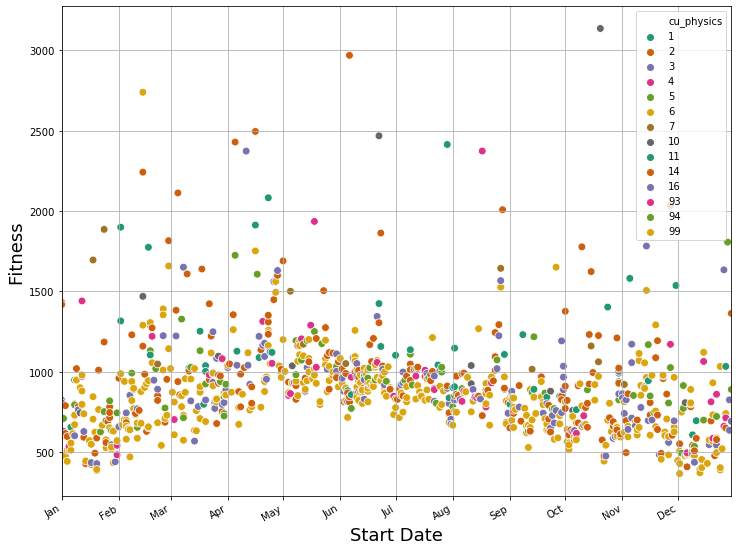

In [43]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.cu_physics, legend="full", palette=cmap6, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_cu.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [44]:
# Set1; n = 5; desat = 1.00
cmap7 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

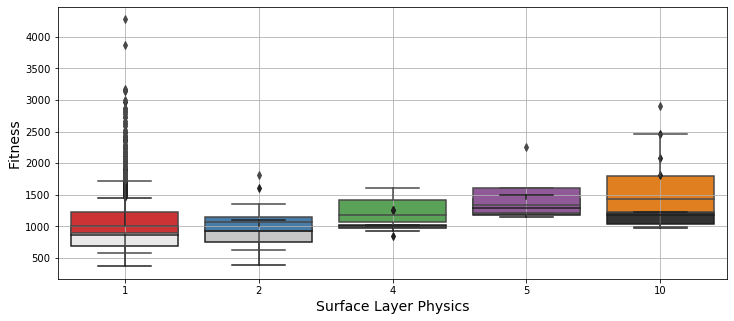

In [46]:
# Plot surface layer option vs. Fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='sf_sfclay_physics', y='fitness', data=data, palette=cmap7)
sns.boxplot(x='sf_sfclay_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='sf_sfclay_physics', y='fitness_corrected', data=data, palette=cmap7)
plt.xlabel('Surface Layer Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvsfclay.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

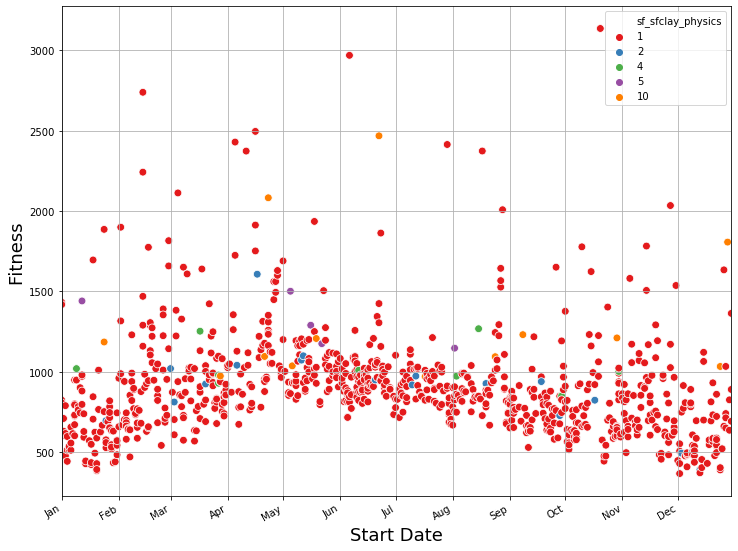

In [58]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, fitness, hue=data.sf_sfclay_physics, legend="full", palette=cmap7, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_sfclay.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Text(0, 0.5, 'Fitness')

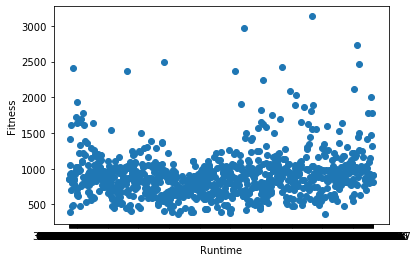

In [59]:
# Plot runtime vs fitness
data = data.sort_values(by='mp_physics')
runtime = data.runtime
fitness = data.fitness

fig, ax = plt.subplots()
plt.scatter(runtime, fitness)
plt.xlabel('Runtime')
plt.ylabel('Fitness')

## Heatmap showing the overall correlation matrix

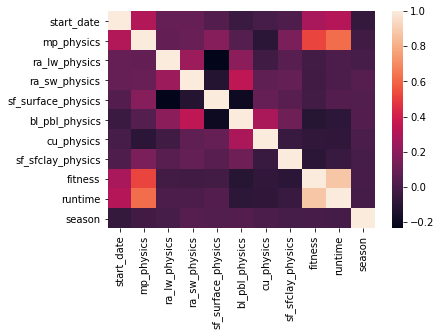

In [60]:
# Plot an overall heatmap
corr_matrix = data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_matrix)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Heatmap_overall.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')